In [13]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import RDLogger
import os
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns


In [2]:

file_path = "data1.csv"  
data = pd.read_csv(file_path, encoding='latin1', low_memory=False)
num_rows = data.shape[0]
num_rows

20309

In [3]:
smiles_column = "Ligand SMILES"
ic50_column = "IC50 (nM)"
reactant_set_id_column = "BindingDB Reactant_set_id"

data[ic50_column] = pd.to_numeric(data[ic50_column], errors='coerce')

# Filter active molecules (IC50 0-10 nM)
active_molecules = data[(data[ic50_column] > 0) & (data[ic50_column] <= 10)].dropna(subset=[smiles_column])

# Remove duplicate SMILES
active_molecules = active_molecules.drop_duplicates(subset=[smiles_column])

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

descriptor_results = []

for index, row in active_molecules.iterrows():
    smi = row[smiles_column]
    reactant_set_id = row[reactant_set_id_column]
    ic50_value = row[ic50_column]

    try:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            hba = Descriptors.NumHAcceptors(mol)
            hbd = Descriptors.NumHDonors(mol)
            rot_bonds = Descriptors.NumRotatableBonds(mol)

            descriptor_results.append({
                'SMILES': smi,
                'Reactant_set_id': reactant_set_id,
                'IC50 (nM)': ic50_value,
                'MW': mw,
                'LogP': logp,
                'HBA': hba,
                'HBD': hbd,
                'Rotatable Bonds': rot_bonds
            })
    except Exception as e:
        print(f"Error processing SMILES: {smi}. Error: {e}")

descriptor_df = pd.DataFrame(descriptor_results)

output_file = "active_molecules_descriptors.csv"
descriptor_df.to_csv(output_file, index=False)

print(f"Descriptor calculations complete. Results saved to {output_file}.")

Descriptor calculations complete. Results saved to active_molecules_descriptors.csv.


In [4]:
input_file = "active_molecules_descriptors.csv" 
descriptor_df = pd.read_csv(input_file)
num_rows_1=descriptor_df.shape[0]
num_rows_1

2505

In [5]:
# Lipinski's Rule of Five criteria
lipinski_conditions = (
    (descriptor_df['MW'] <= 500) & 
    (descriptor_df['LogP'] <= 5) & 
    (descriptor_df['HBD'] <= 5) & 
    (descriptor_df['HBA'] <= 10)
)

lipinski_accepted = descriptor_df[lipinski_conditions]

# Sort molecules based on IC50
lipinski_accepted_sorted = lipinski_accepted.sort_values(by='IC50 (nM)')

output_file = "lipinski_accepted_molecules.csv"
lipinski_accepted_sorted.to_csv(output_file, index=False)

print(f"No molecules accepted by Lipinski's Rule: {len(lipinski_accepted)}")
print(f"Results saved to {output_file}.")


No molecules accepted by Lipinski's Rule: 841
Results saved to lipinski_accepted_molecules.csv.


In [6]:
input_file = "lipinski_accepted_molecules.csv"
descriptor_df = pd.read_csv(input_file)
top_10_molecules = descriptor_df.head(10)

# Create a directory
pdb_output_dir = "pdb_files"
os.makedirs(pdb_output_dir, exist_ok=True)  

for index, row in top_10_molecules.iterrows():
    smi = row['SMILES']
    reactant_id = row.get('Reactant_set_id', f"molecule_{index}")  # if Reactant_set_id is missing

    try:
        # Generate molecule from SMILES
        mol = Chem.MolFromSmiles(smi)
        if mol:
            # Generate 3D str
            AllChem.EmbedMolecule(mol)
            AllChem.UFFOptimizeMolecule(mol)

            pdb_file = os.path.join(pdb_output_dir, f"{reactant_id}.pdb")
            with open(pdb_file, "w") as f:
                f.write(Chem.MolToPDBBlock(mol))
            
            print(f"PDB file created for Reactant_set_id {reactant_id}: {pdb_file}")
        else:
            print(f"Failed to generate molecule from SMILES: {smi}")
    except Exception as e:
        print(f"Error processing SMILES: {smi}. Error: {e}")
print("PDB conversion process completed.")

PDB file created for Reactant_set_id 5318: pdb_files\5318.pdb
PDB file created for Reactant_set_id 5366: pdb_files\5366.pdb
PDB file created for Reactant_set_id 5365: pdb_files\5365.pdb
PDB file created for Reactant_set_id 5332: pdb_files\5332.pdb
PDB file created for Reactant_set_id 5334: pdb_files\5334.pdb
PDB file created for Reactant_set_id 1055477: pdb_files\1055477.pdb
PDB file created for Reactant_set_id 1055475: pdb_files\1055475.pdb
PDB file created for Reactant_set_id 1055485: pdb_files\1055485.pdb
PDB file created for Reactant_set_id 1055483: pdb_files\1055483.pdb
PDB file created for Reactant_set_id 5336: pdb_files\5336.pdb
PDB conversion process completed.


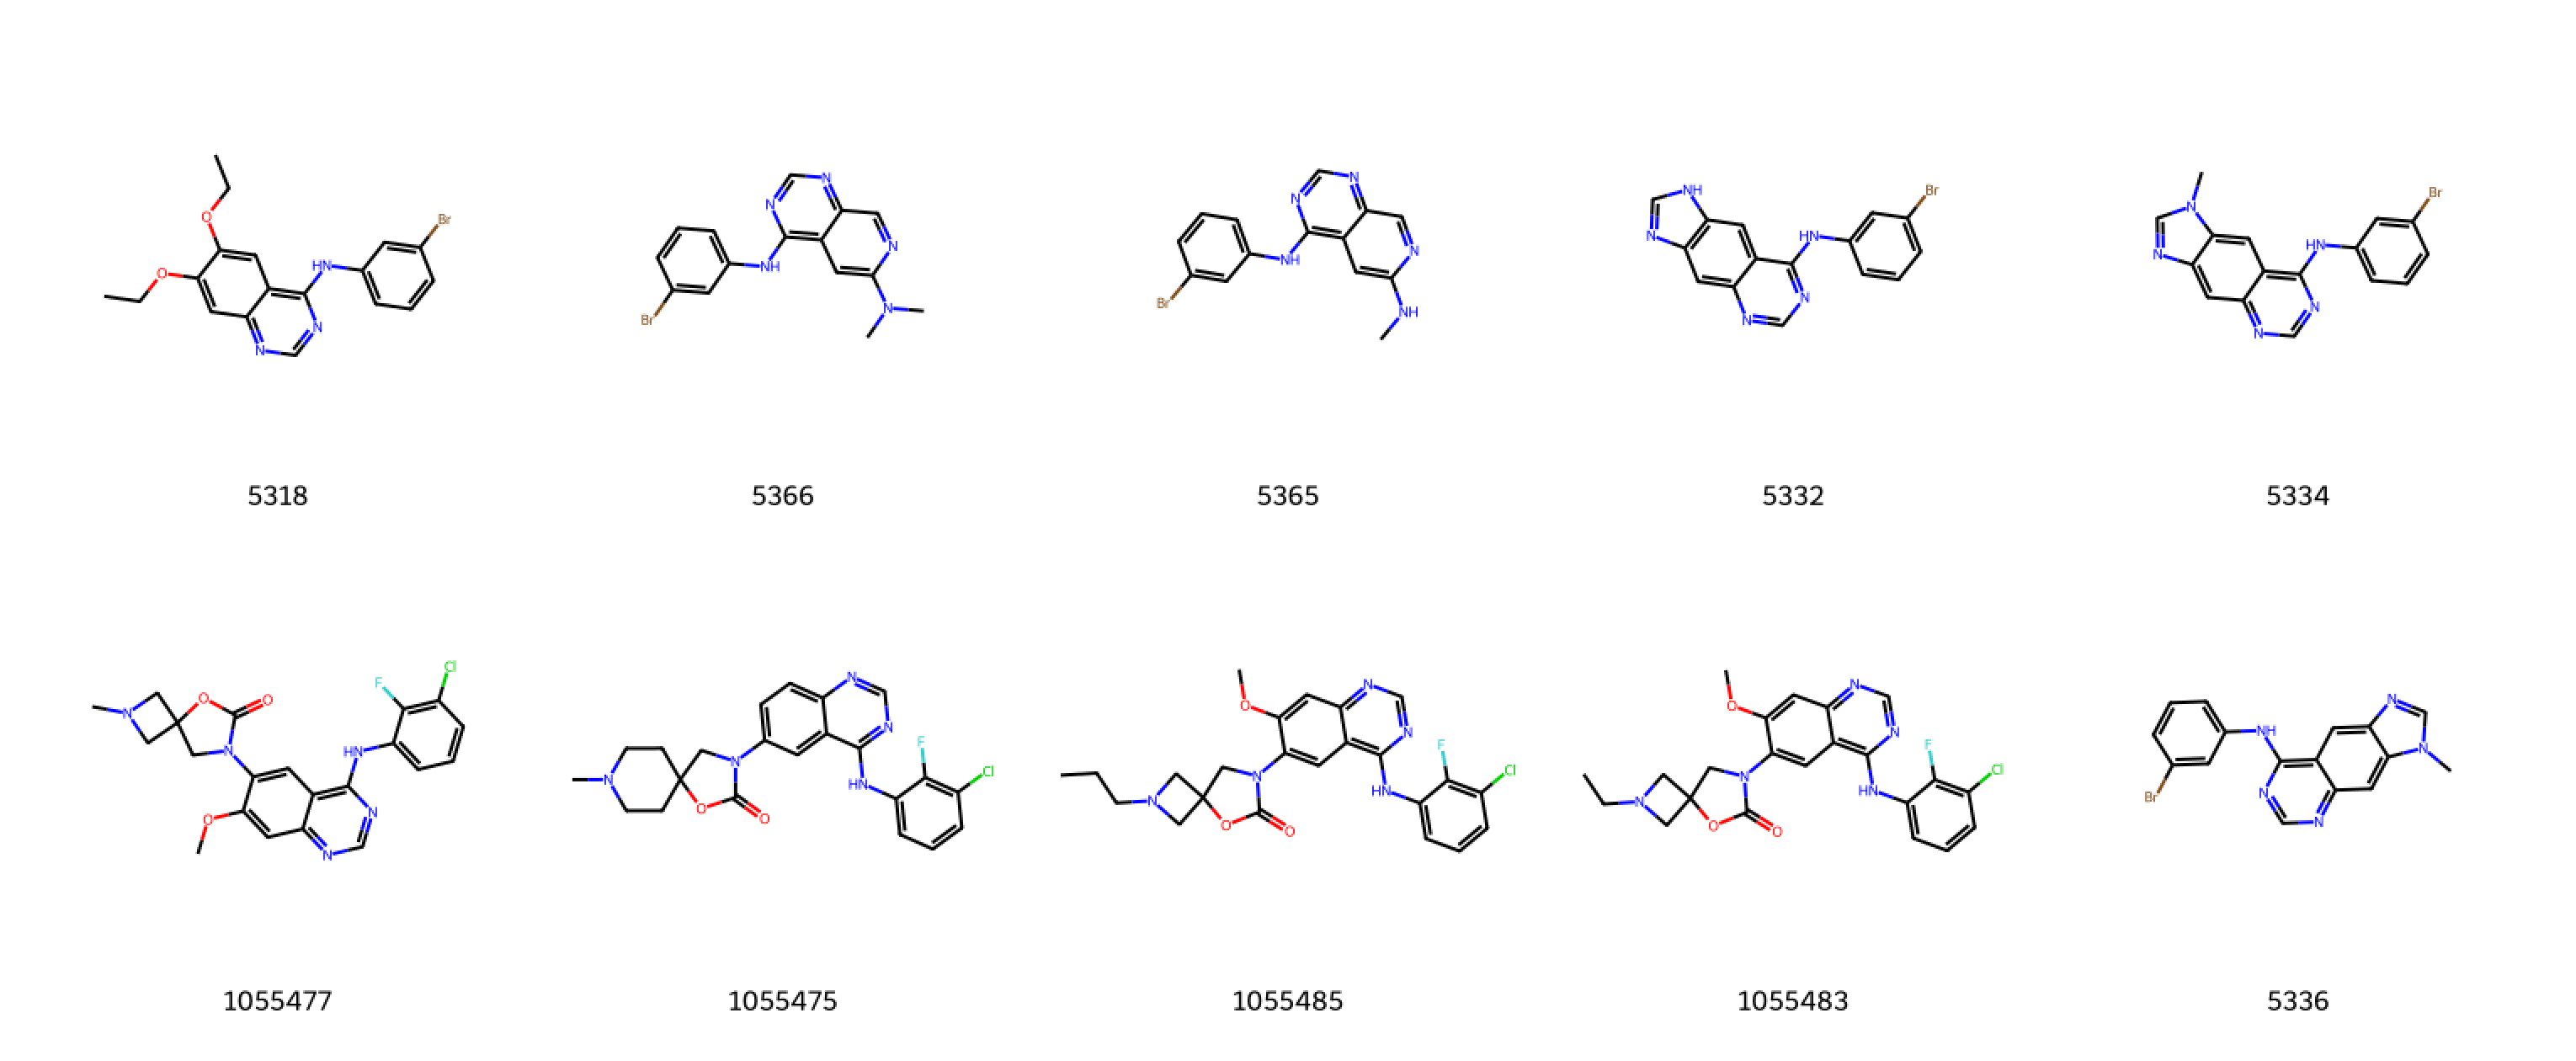

Molecule grid image with annotations saved as 'molecule_dock_annotated.png'.


In [27]:
molecule_list = []
reactant_ids = []

for index, row in top_10_molecules.iterrows():
    smi = row['SMILES']
    reactant_id = row.get('Reactant_set_id', f"molecule_{index}")  # Fallback ID
    try:
        # Generate molecule from SMILES
        mol = Chem.MolFromSmiles(smi)
        if mol:
            molecule_list.append(mol)
            reactant_ids.append(str(reactant_id))
        else:
            print(f"Failed to generate molecule from SMILES: {smi}")
    except Exception as e:
        print(f"Error processing SMILES: {smi}. Error: {e}")

if molecule_list:
    img = Draw.MolsToGridImage(
        molecule_list,
        molsPerRow=5,  
        subImgSize=(300, 300),  
        legends=reactant_ids,  
        returnPNG=False 
    )

    # Display and save 
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    ax.imshow(img)
    ax.axis("off")  
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0) 

    # Save the figure 
    plt.savefig("molecule_dock_annotated.png", transparent=True, bbox_inches="tight", pad_inches=0, dpi=300)
    plt.show()

    print("Molecule grid image with annotations saved as 'molecule_dock_annotated.png'.")
else:
    print("No valid molecules to display.")


In [33]:
descriptor_df = pd.read_csv(input_file)
print(descriptor_df.columns)


Index(['SMILES', 'Reactant_set_id', 'IC50 (nM)', 'MW', 'LogP', 'HBA', 'HBD',
       'Rotatable Bonds'],
      dtype='object')


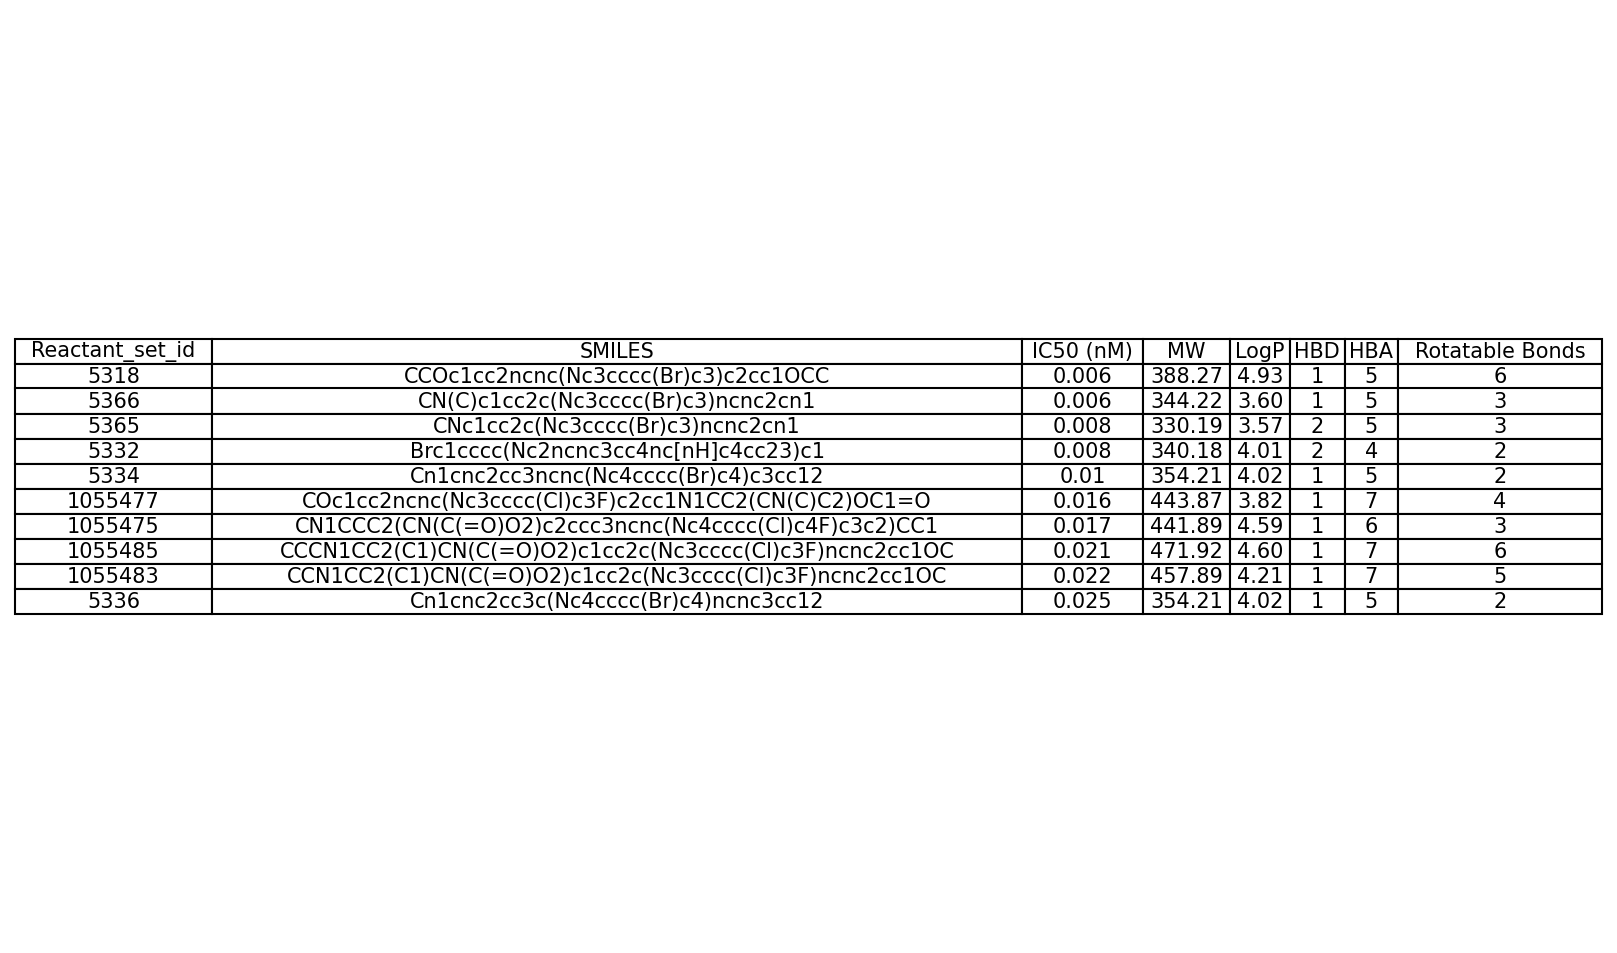

Text-only molecule table saved as 'molecule_table_text_only.png'.


In [ ]:
table_data = []

for index, row in top_10_molecules.iterrows():
    smi = row['SMILES']
    reactant_id = row.get('Reactant_set_id', f"molecule_{index}")  
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mw = Descriptors.MolWt(mol)  # Molecular weight
            logp = Descriptors.MolLogP(mol)  # LogP
            hbd = Descriptors.NumHDonors(mol)  # H-bond donors
            hba = Descriptors.NumHAcceptors(mol)  # H-bond acceptors
            rot_bonds = Descriptors.NumRotatableBonds(mol)  # Rotatable bonds
            
            ic50 = row.get('IC50 (nM)', 'N/A')  
            table_data.append({
                "Reactant_set_id": reactant_id,
                "SMILES": smi,
                "IC50 (nM)": ic50,  
                "MW": f"{mw:.2f}",
                "LogP": f"{logp:.2f}",
                "HBD": hbd,
                "HBA": hba,
                "Rotatable Bonds": rot_bonds
            })
        else:
            print(f"Failed to generate molecule from SMILES: {smi}")
    except Exception as e:
        print(f"Error processing SMILES: {smi}. Error: {e}")

df = pd.DataFrame(table_data)

fig, ax = plt.subplots(figsize=(12, len(df) * 0.8), dpi=150)
ax.axis("off")

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

plt.savefig("molecule_table_text_only.png", bbox_inches="tight")
plt.show()

print("Text-only molecule table saved as 'molecule_table_text_only.png'.")


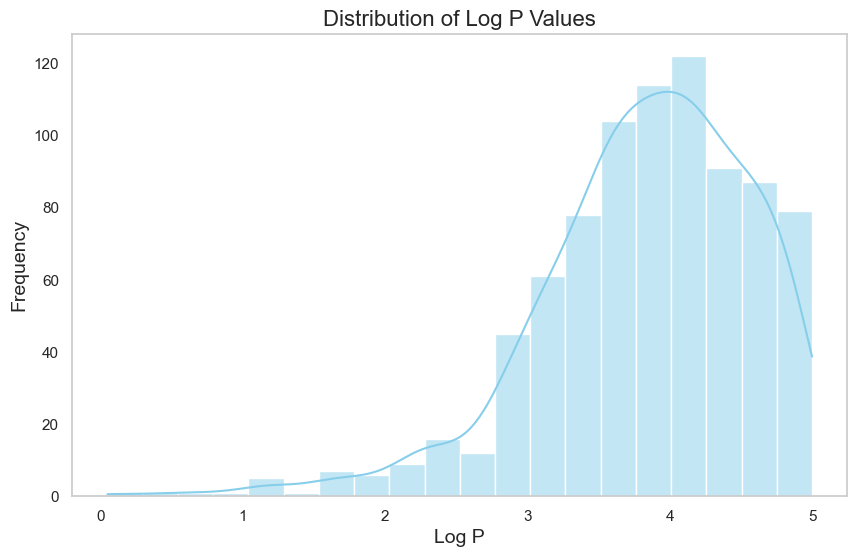

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

descriptor_df = pd.read_csv("lipinski_accepted_molecules.csv")  

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(descriptor_df['LogP'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Log P Values', fontsize=16)
plt.xlabel('Log P', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(False)
plt.show()
